<a href="https://colab.research.google.com/github/Kavyank8/Student_performance-_Analyzer/blob/main/Studentdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset shape: (500, 11)
  student_id           name class  comprehension  attention  focus  retention  \
0      S1000  Krishna Verma  CS-A          70.96      74.76  81.89      70.84   
1      S1001    Aarav Kohli  CS-B          63.34      86.62  77.38      52.76   
2      S1002    Aadhya Iyer  CS-D          72.77      44.75  57.73      49.66   
3      S1003     Saanvi Rao  CS-C          83.28      71.51  52.66      61.25   
4      S1004     Sara Verma  CS-C          62.19      53.20  68.19      56.16   

   engagement_time  assessment_score  cluster                 persona  
0            121.4             71.01        2  Engaged but struggling  
1            140.1             70.56        0  Engaged but struggling  
2             86.0             50.46        1          Average steady  
3            110.4             59.46        1          Average steady  
4             64.5             47.83        3          Average steady  


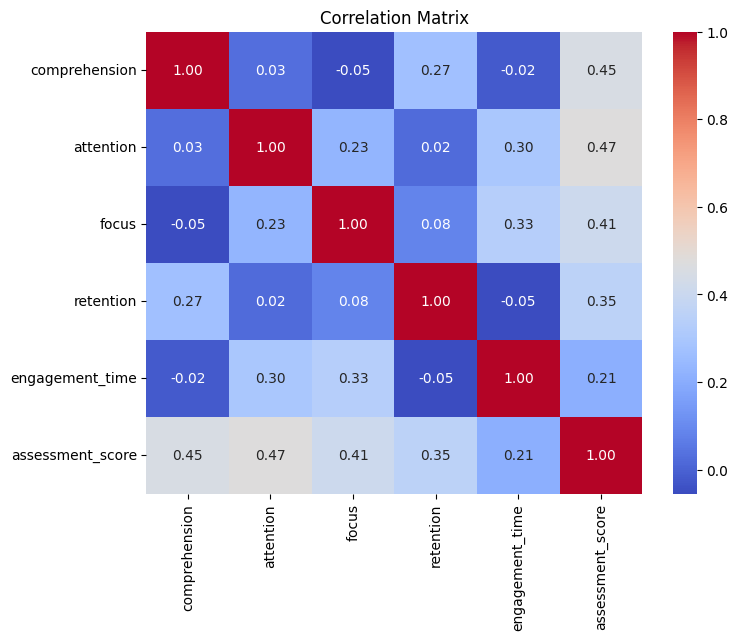

Linear Regression -> MAE: 4.54, RMSE: 5.73, R2: 0.61
Random Forest -> MAE: 4.73, RMSE: 6.17, R2: 0.55

Feature Importances:
            feature  linear_coef  rf_importance
0    comprehension        0.308          0.293
1        attention        0.262          0.276
2            focus        0.218          0.217
3        retention        0.168          0.138
4  engagement_time       -0.005          0.076

Cluster Summary:
          comprehension  attention  focus  retention  engagement_time  \
cluster                                                                
0                56.79      69.31  71.94      50.37           144.91   
1                71.71      67.57  67.39      67.49           140.36   
2                75.29      54.73  49.64      64.36            92.31   
3                58.12      57.60  56.43      52.34           104.09   

         assessment_score  count  
cluster                           
0                   57.11    109  
1                   63.31    142  
2

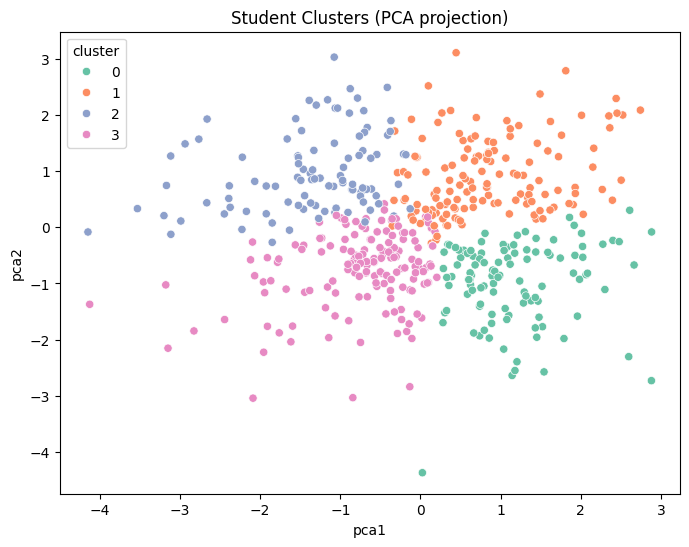


Updated dataset saved: synthetic_students_500_with_personas.csv


In [3]:
# student_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv("synthetic_students_500.csv")
print("Dataset shape:", df.shape)
print(df.head())

features = ["comprehension","attention","focus","retention","engagement_time"]
corr = df[features + ["assessment_score"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
-
X = df[features].values
y = df["assessment_score"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --- Fixed evaluate function ---
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # always returns MSE
    rmse = np.sqrt(mse)                        # manual square root
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")

# Feature importance
coef_df = pd.DataFrame({
    "feature": features,
    "linear_coef": np.round(lr.coef_, 3),
    "rf_importance": np.round(rf.feature_importances_, 3)
}).sort_values("rf_importance", ascending=False)
print("\nFeature Importances:\n", coef_df)

# -------------------------
# 4. Clustering
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Cluster summary
cluster_summary = df.groupby("cluster")[features + ["assessment_score"]].mean().round(2)
cluster_summary["count"] = df["cluster"].value_counts().sort_index()
print("\nCluster Summary:\n", cluster_summary)

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df["pca1"], df["pca2"] = X_pca[:,0], X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=df, palette="Set2")
plt.title("Student Clusters (PCA projection)")
plt.show()

# -------------------------
# 5. Persona labeling
# -------------------------
def label_persona(row):
    if row['comprehension']>70 and row['attention']>68 and row['assessment_score']>70:
        return "High-achiever"
    if row['comprehension']<55 and row['attention']<55 and row['assessment_score']<55:
        return "Needs foundational support"
    if row['engagement_time']>140 and row['assessment_score']<65:
        return "Engaged but struggling"
    return "Average steady"

df["persona"] = df.apply(label_persona, axis=1)


df.to_csv("synthetic_students_500_with_personas.csv", index=False)
print("\nUpdated dataset saved: synthetic_students_500_with_personas.csv")

